In [3]:
import plotly
import matplotlib.pyplot as plt
import uproot
import numpy as np

In [125]:
# ntup = '/home/sys-ad/Desktop/phys165/hgcalNtuple_1000_1.root'
# event = uptools.get_event_rootfile(ntup, 100)
# event['gunparticle_id']

In [4]:
ntuple = uproot.open('/home/sys-ad/Desktop/phys165/hgcalNtuple_1000_1.root')
tree = ntuple['ana/hgc']
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | uint64_t                 | AsDtype('>u8')
lumi                 | uint32_t                 | AsDtype('>u4')
run                  | uint32_t                 | AsDtype('>u4')
vtx_x                | float                    | AsDtype('>f4')
vtx_y                | float                    | AsDtype('>f4')
vtx_z                | float                    | AsDtype('>f4')
genpart_eta          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
genpart_phi          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
genpart_pt           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
genpart_energy       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
genpart_dvx          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
genpart_dvy          | std::vector<float>  

In [86]:
tree['genpart_eta'].array()

<Array [[2.56, -2.56, -2.56, ... 1.8, 1.79]] type='400 * var * float32'>

(array([15.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([1.0159642e-01, 1.0009096e+02, 2.0008032e+02, 3.0006970e+02,
        4.0005905e+02, 5.0004843e+02, 6.0003778e+02, 7.0002716e+02,
        8.0001654e+02, 9.0000586e+02, 9.9999524e+02], dtype=float32),
 <BarContainer object of 10 artists>)

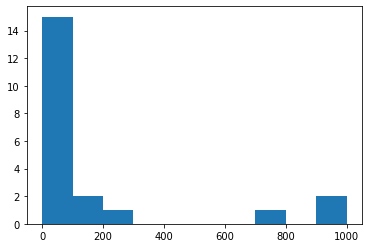

In [108]:
plt.hist(tree['genpart_energy'].array()[399])

(array([ 3736., 14755.,   217.,     0.,     0.,     0.,     0.,   182.,
        14528.,  3942.]),
 array([-3.516615 , -2.8142407, -2.1118665, -1.4094921, -0.7071179,
        -0.0047437,  0.6976305,  1.4000047,  2.102379 ,  2.8047533,
         3.5071275], dtype=float32),
 <BarContainer object of 10 artists>)

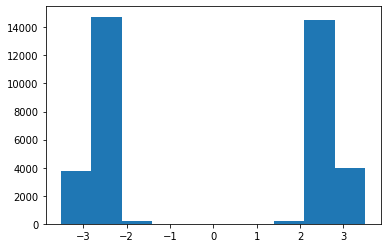

In [88]:
plt.hist(tree['rechit_eta'].array()[100])

Text(0.5, 0, 'y')

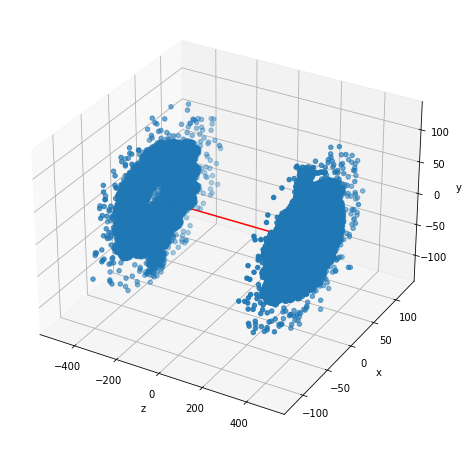

In [101]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
ax.scatter(tree['rechit_z'].array()[1], tree['rechit_x'].array()[1], tree['rechit_y'].array()[1])
ax.plot([-320., 320.], [0,0], [0,0], color='r') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')

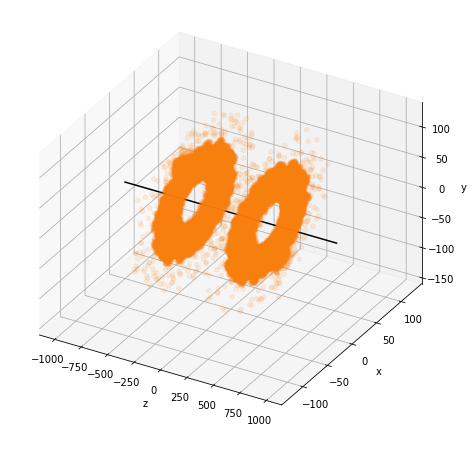

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
ax.scatter(tree['rechit_z'].array()[0], 
           tree['rechit_x'].array()[0], 
           tree['rechit_y'].array()[0],
           color = "tab:orange",
           alpha = 0.1)
ax.plot([-1000., 1000.], [0,0], [0,0], color='k') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_proj_type('ortho')
#ax.view_init(0, 90)

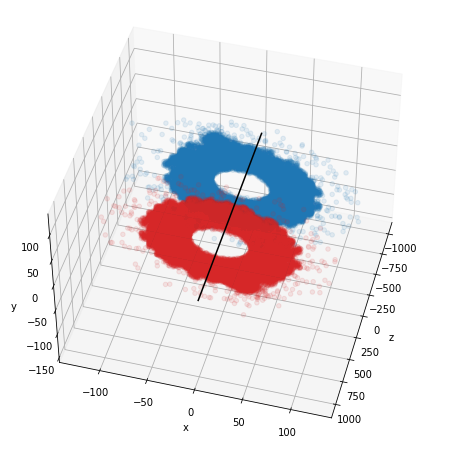

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
mask = tree['rechit_z'].array()[0] < 0 
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:blue')
mask = tree['rechit_z'].array()[0] > 0
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:red')
ax.plot([-1000., 1000.], [0,0], [0,0], color='k',zorder = 100) 
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(45, 15)

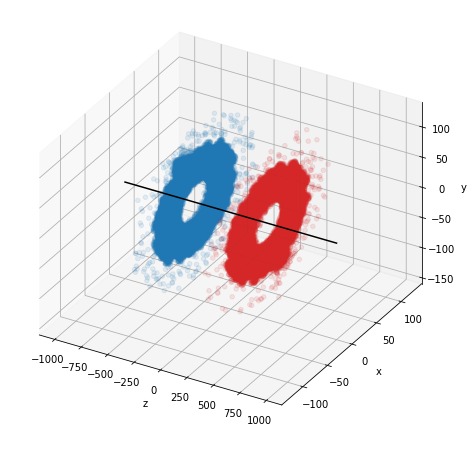

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
mask = tree['rechit_z'].array()[0] < 0 
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:blue')
mask = tree['rechit_z'].array()[0] > 0
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:red')
ax.plot([-1000., 1000.], [0,0], [0,0], color='k', zorder = 100) 
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_proj_type('ortho')